<a href="https://colab.research.google.com/github/YasmineeBa/Learn-Pytorch-Deep-learning/blob/main/replicating_papers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# use transformers to 

# Pytorch Paper Replicating

The goal of machine learning research paper replicating is : turn a ML research paper into usable code.


## 0.Getting setup

import libraries

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary # to display the architecture of the model

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
from torch._C import DeviceObjType
#setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
device
 


'cuda'

# 1. Get DATA

In [ ]:
#download data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# 2. Create Datasets and DataLoaders

In [ ]:
!nvidia-smi

Sat Apr 29 07:59:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    599MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from going_modular.going_modular import data_setup

#create image size

IMG_SIZE = 224 # comes from paper of VIT

#create transforms pipline
manual_tranforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])

In [ ]:
from torch.cuda.random import manual_seed
print(f"Manualy created transforms: {manual_tranforms}")

Manualy created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
#create a batch size of 32 

BATCH_SIZE = 32

#create dataloader

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
      train_dir = train_dir,
      test_dir = test_dir,
      transform = manual_tranforms,
      batch_size = BATCH_SIZE

)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

# 2.3 Visualize a single image

In [ ]:
#Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

#Get a single image and label from the batch

image, label = image_batch[0], label_batch[0]

#View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

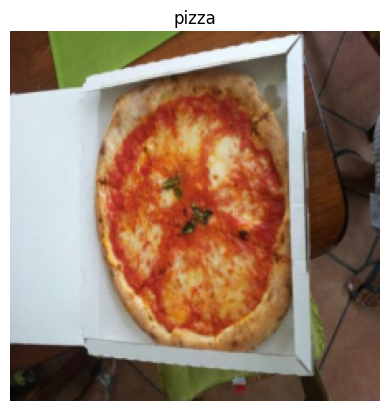

In [ ]:
#plot the images with matplotlib

import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))# color chanel, height, width -> height, width, color chanel
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the ViT paper: an overview

Before we write anymore code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our **model inputs** are: images of pizza, steak and sushi.

And our ideal **model outputs** are: predicted labels of pizza, steak or sushi.


The question is: how do we go from our inputs to the desired outputs?

### 3.1 Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of **layers**.

And a collection of layers is often referred to as a **block**.

And stacking many blocks together is what gives us the whole architecture.

A **layer** takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's `forward()` method) and then returns an output.

So if a **single layer** takes an input and gives an output, then a collection of layers or a **block** also takes an input and gives an output.

Let's make this concrete:
* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png" alt="inputs and outputs, layers and blocks of a model" width=900/>

*A modern deep learning architecture is usually collection of layers and blocks. Where layers take an input (data as a numerical representation) and manipulate it using some kind of function (for example, the self-attention formula pictured above, however, this function could be almost anything) and then output it. Blocks are generally stacks of layers on top of each other doing a similar thing to a single layer but multiple times.* 

#### 3.2.1 Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.* 

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1). 
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast. 

> **Note:** We're going to focused on write PyTorch code to create these layers, for the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

In [ ]:
#input shape: (224, 224, 3)
#Equation 1 : split data into patches  and creating class, position, and patch embedding



In [ ]:
height = 224
width = 224
color_channels = 3
patch_size = 16

#calculate the number of patches

number_of_patches = int((height * width) / patch_size **2)
number_of_patches


196

In [ ]:
#Input shape 
embedding_layer_input_shape = (height, width, color_channels)


#Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels) #patch_size = 16

print(f"Input shape (single 2d image) :{embedding_layer_input_shape}")
print(f"Output shape (single 2d image) :{embedding_layer_output_shape}")




Input shape (single 2d image) :(224, 224, 3)
Output shape (single 2d image) :(196, 768)


(-0.5, 223.5, 223.5, -0.5)

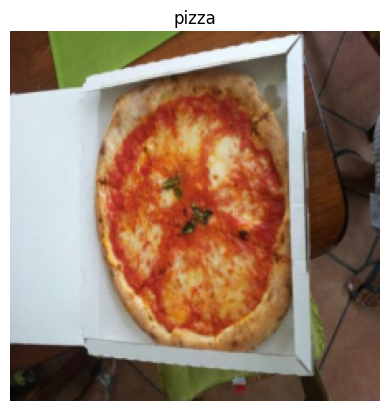

In [ ]:
 plt.imshow(image.permute(1,2,0))
 plt.title(class_names[label])
 plt.axis(False)


In [ ]:
image

tensor([[[0.3020, 0.2980, 0.2980,  ..., 0.1843, 0.2039, 0.2471],
         [0.2902, 0.2980, 0.3020,  ..., 0.1922, 0.1804, 0.2196],
         [0.2980, 0.3020, 0.2941,  ..., 0.1765, 0.1725, 0.1882],
         ...,
         [0.0353, 0.0431, 0.0471,  ..., 0.4510, 0.4549, 0.4549],
         [0.0549, 0.0510, 0.0510,  ..., 0.4431, 0.4471, 0.4471],
         [0.0431, 0.0431, 0.0588,  ..., 0.4471, 0.4471, 0.4471]],

        [[0.1647, 0.1608, 0.1608,  ..., 0.1294, 0.1373, 0.1725],
         [0.1529, 0.1608, 0.1647,  ..., 0.1412, 0.1176, 0.1451],
         [0.1608, 0.1647, 0.1569,  ..., 0.1333, 0.1176, 0.1255],
         ...,
         [0.0235, 0.0275, 0.0314,  ..., 0.3176, 0.3216, 0.3216],
         [0.0392, 0.0353, 0.0353,  ..., 0.3098, 0.3137, 0.3137],
         [0.0275, 0.0275, 0.0431,  ..., 0.3137, 0.3137, 0.3137]],

        [[0.0784, 0.0745, 0.0784,  ..., 0.0196, 0.0510, 0.1020],
         [0.0667, 0.0745, 0.0863,  ..., 0.0314, 0.0275, 0.0706],
         [0.0784, 0.0824, 0.0784,  ..., 0.0275, 0.0275, 0.

In [ ]:
image.shape

torch.Size([3, 224, 224])

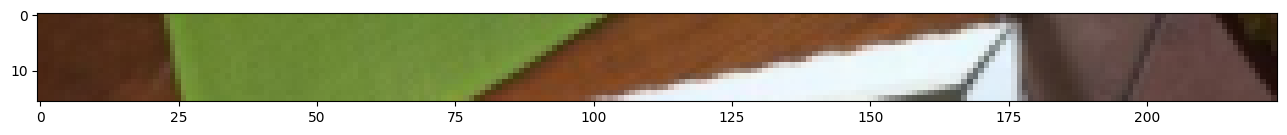

In [ ]:
#get the top row 

image_permuted = image.permute(1,2,0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);


* Now, we have got the top row, let's turn it into patches

Number of patches per row: 14.0
 Patch size: 16 pixels x 16 pixels


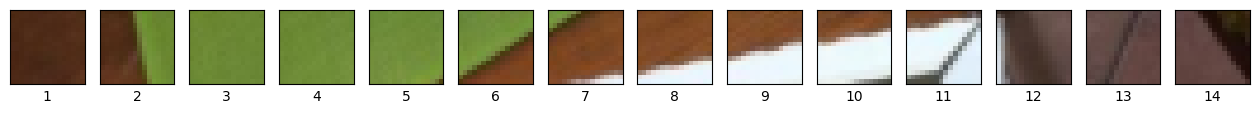

In [ ]:
# Setup hyperparameters and make suzre img_size and patch_size are compatible

img_size = 224
patch_size = 16
num_patch = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patch}\n Patch size: {patch_size} pixels x {patch_size} pixels")

#create a serie of subplots
figs, axs = plt.subplots(nrows =1,
                        ncols=img_size // patch_size,
                        figsize=(patch_size, patch_size),
                        sharex = True,
                        sharey=True
                        )
#iterate throught number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); #let or make index of the height constant, alter index of width
  axs[i].set_xlabel(i+1) # set the label
  axs[i].set_xticks([])
  axs[i].set_yticks([])



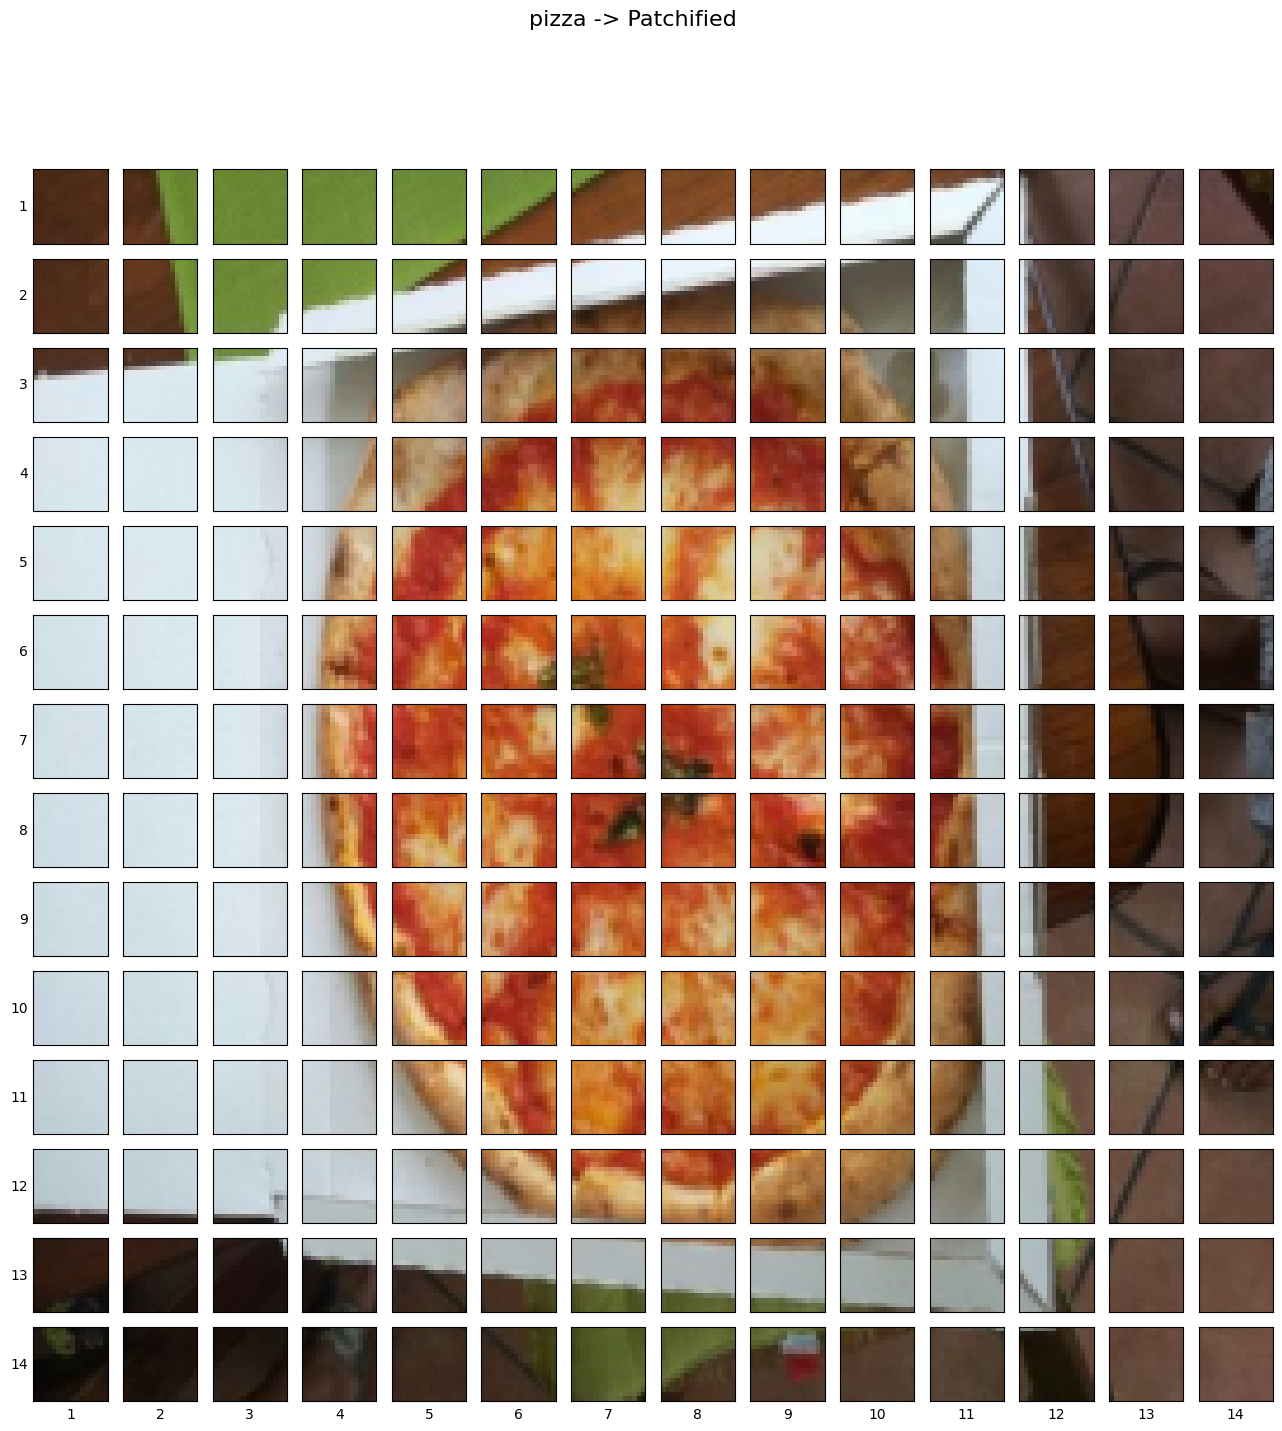

In [ ]:
#this time, we will iterate throught the index f height and width and plot each patche as it own subplot

#create a serie of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         figsize=(patch_size, patch_size),
                         sharex=True,
                         sharey=True
) 
for i , patch_row in enumerate(range(0, img_size, patch_size)):
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    
    axs[i][j].imshow(image_permuted[patch_row: patch_row+patch_size, patch_col: patch_col+patch_size, :])
    axs[i][j].set_ylabel(i+1, 
                   rotation="horizontal", 
                   horizontalalignment="right", 
                   verticalalignment="center") 
                         
    axs[i][j].set_xlabel(j+1)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

## Image patchified!

Woah, that looks cool.

Now how do we turn each of these patches into an embedding and convert them into a sequence?

# cretae image patches and turning them into patches embeddings

In [ ]:
from torch import nn
# set the patch size 
patch_size = 16
conv2d = nn.Conv2d(in_channels=3, # for color images 
                   out_channels= 768, # dimension mentionned in the paper from table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding =0)

conv2d


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

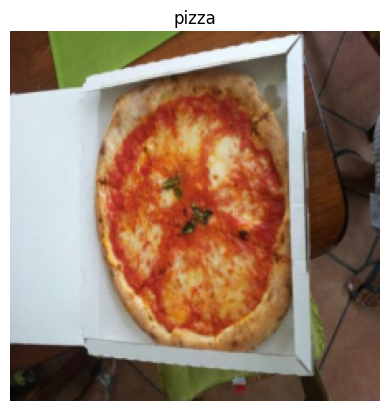

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
#Pass the image through the convolutional layer

image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [ ]:
image_out_of_conv.requires_grad

True

Now we have passed a single image to our conv2d layer, it's shape is:
```python
torch.Size([1, 768, 14,14]) #batch_size, embedding_dim, height feature map, width feature map

```

showing random convolution feature maps from indexes: [564, 374, 5, 412, 723]


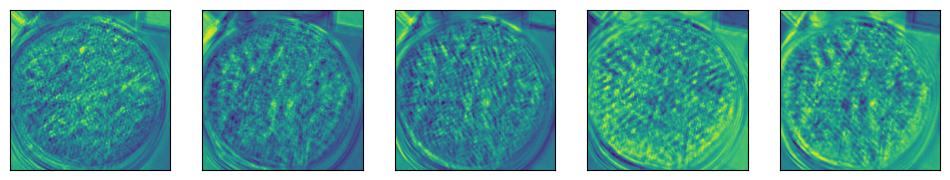

In [ ]:
# plot random convolution feature map (embeddings)

import random
random_indexes= random.sample(range(0, 768), k=5)
print(f'showing random convolution feature maps from indexes: {random_indexes}')

#create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i , idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_conv[:, idx, :,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [ ]:
image_conv_feature_map

tensor([[[ 3.4571e-02,  2.0881e-02,  1.1498e-02,  ..., -2.4278e-01,
          -2.4485e-01, -2.3530e-01],
         [ 5.7865e-02,  5.0782e-02,  4.9387e-02,  ..., -2.4455e-01,
          -2.5409e-01, -2.4775e-01],
         [-8.3240e-03,  8.5547e-02,  1.0547e-01,  ..., -2.4833e-01,
          -2.5685e-01, -2.5624e-01],
         ...,
         [-1.4310e-01, -1.5130e-01, -1.4578e-01,  ...,  2.5206e-03,
           5.1067e-03, -2.4509e-03],
         [-1.2576e-01, -1.3150e-01, -1.3410e-01,  ...,  1.4959e-03,
           4.0439e-03,  1.1947e-03],
         [-1.2463e-01, -1.2682e-01, -1.3252e-01,  ..., -2.5275e-04,
           2.0252e-03,  1.7986e-03]]], grad_fn=<SliceBackward0>)

### 4.4 Flattenning the patch embedding with torch.nn.Flatten()

Right now we have a series of convolution feature maps that we want to flatten into a sequence


In [ ]:
 flatten_layer = nn.Flatten(start_dim=2,
                            end_dim=3)
 flatten_layer(image_out_of_conv).shape 

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


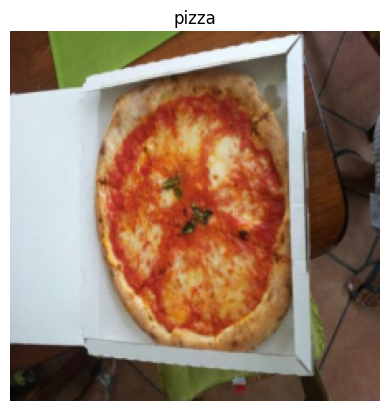

In [ ]:
  # Now let's put it all to gather
  # 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


In [ ]:
#num_patches = 14*14=196

In [ ]:
#get a single flatten feature map

single_flattended_feature_map= image_out_of_conv_flattened_reshaped[:,:,0]
single_flattended_feature_map

tensor([[-0.0414,  0.0190, -0.1026, -0.1038, -0.1101,  0.0228, -0.1120, -0.3258,
         -0.4015, -0.3368, -0.0949, -0.0268, -0.0864, -0.1025, -0.0591, -0.0686,
         -0.0833, -0.3374, -0.3080, -0.0157,  0.1102,  0.0143, -0.0563, -0.0717,
         -0.0440, -0.0575, -0.0733, -0.0697, -0.3141, -0.3597, -0.3418, -0.1627,
         -0.1484, -0.0730,  0.0128, -0.0405, -0.0015, -0.0677, -0.0918,  0.0133,
         -0.0538, -0.0680, -0.2415, -0.2475, -0.2426, -0.2254, -0.0699, -0.0173,
         -0.0658, -0.1393, -0.0898, -0.0139, -0.0735, -0.0505, -0.0836, -0.0609,
         -0.2412, -0.2453, -0.2497, -0.1337, -0.1316,  0.0296, -0.0059, -0.0694,
         -0.1811, -0.0625, -0.0717, -0.0569, -0.0247, -0.1191, -0.2425, -0.2404,
         -0.2397, -0.1027, -0.0624,  0.0046, -0.0465,  0.0344, -0.1361, -0.0261,
         -0.0364, -0.0839, -0.0255, -0.0806, -0.2362, -0.2399, -0.2418, -0.0718,
         -0.0433, -0.0601, -0.1045, -0.0402, -0.1292, -0.1140, -0.0017, -0.0777,
         -0.0641, -0.1070, -

(-0.5, 195.5, 0.5, -0.5)

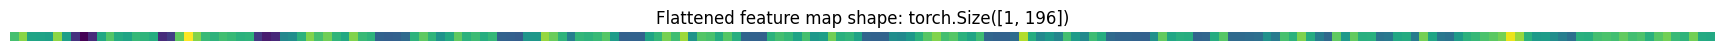

In [ ]:
plt.figure(figsize=(22,22))
plt.imshow(single_flattended_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattended_feature_map.shape}')
plt.axis(False)


In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])
